In [3]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost
from xgboost import XGBClassifier
from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from datetime import datetime


from IPython.core.pylabtools import figsize 
%matplotlib inline

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [4]:
RANDOM_STATE = 42
DATA_EXTERNAL = "../data/external/"
DATA_PROCESSED = "../data/processed/"
DATA_INTERIM = "../data/interim/"

In [5]:
full = pd.read_csv("../data/processed/varq_integral/dataset.csv.gz", index_col="MUTANT")

In [6]:
model_dict = {
    'xgb':{'pipe':('xgb', XGBClassifier(learning_rate=0.01, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)),
          'params':[{'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 
                     'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]
        }],
          'name':'Xtreme Gradient Boosting'
    },
}

In [7]:
folds = 3
param_comb = 10
algorithm = 'xgb'
model = model_dict[algorithm]['pipe'][1]
param_list = model_dict[algorithm]['params'][0]
rs = RandomizedSearchCV(model, param_distributions=param_list, n_iter=param_comb, scoring='roc_auc', 
                        n_jobs=4, cv=folds, verbose=2, random_state=RANDOM_STATE)

In [8]:
le = LabelEncoder()
X = full[~full.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(full[~full.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [9]:
#### Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
rs.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=0.8, min_child_weight=10, max_depth=4, gamma=1.5, colsample_bytree=0.6 
[CV] subsample=0.8, min_child_weight=10, max_depth=4, gamma=1.5, colsample_bytree=0.6 
[CV] subsample=1.0, min_child_weight=1, max_depth=3, gamma=2, colsample_bytree=0.8 
[CV] subsample=0.8, min_child_weight=10, max_depth=4, gamma=1.5, colsample_bytree=0.6 


KeyboardInterrupt: 

In [ ]:
xgb = rs.best_estimator_ 

In [ ]:
xgb

In [10]:
xgb_fixed = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1.5, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

In [11]:
xgb_fixed.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1.5, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)

In [13]:
pd.DataFrame({"mutant": X_test.index, "score": xgb_fixed.predict_proba(X_test)[:, 1], "label": y_test}).to_csv("../results/varq_integral/scores_xgb.csv", index=False)

In [13]:
_ = xgb_fixed.predict_proba(X_test)[:, 1]

In [12]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(xgb_fixed.predict(X_test))))

             precision    recall  f1-score   support

     Benign       0.80      0.59      0.68       674
 Pathogenic       0.86      0.94      0.90      1774

avg / total       0.84      0.85      0.84      2448



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [34]:
fpr, tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [35]:
roc_auc

0.8826249753277644

In [36]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/varq_integral/auc_xgboost.csv", index=False)

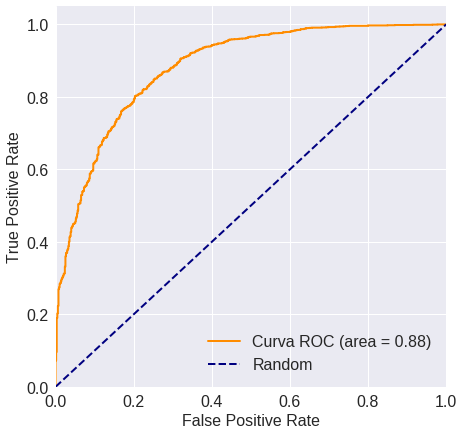

In [37]:
plt.figure(figsize=(7,7))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

In [15]:
features1 = ["GRANTHAM", "EX", "PAM250", "BLOSUM", "JM", "VB"] 
features2 = ["HYDROPHOBICITY", "POLARITY"]
features3 = ["CHARGE", "ISOELECTRIC_POINT_LOG_RATIO"]
features4 = ['PHYLOP46WAY', 'PHASTCONS46WAY']
features5 = ['SASA', 'SASA_PERCENTAGE']

features = X.drop(features1+features2+features3+features4+features5, axis=1).columns.tolist() + [features1] + [features2] + [features3] + [features4] + [features5]

In [17]:
import rfpimp
I = rfpimp.importances(xgb_fixed, X_test, y_test, n_samples=-1, features=features)

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

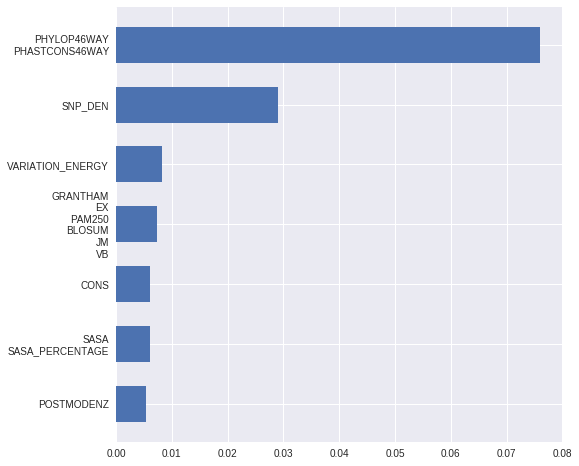

In [18]:
rfpimp.plot_importances(I.iloc[:7], label_fontsize=10, figsize=(8,8), tickstep=1, save="/home/marlan/Desktop/integral_varq_importance_cluster_xgb.pdf")